In [1]:
#required libraries : 
import pandas as pd  # dataframe structure
import numpy as np  # array structure
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plot
import glob, os  # dealing with OS and Files, reading files etc 
import time
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, explained_variance_score
import glob, os  # dealing with OS and Files, reading files etc 
from IPython.display import HTML, display
import tabulate
import pickle # saving model, data, etc : serialization
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Risque de fréquence d'accidents et le risk de gravité associé 

### Problématique : 

Dans ce notebook nous allons nous intéresser à étudier seulement l'impact de la configuration ou la description d'un lieu d'accident sur la fréquence et la gravité des accidents. 

Donc les objectifs sont :
    1. de pouvoir élaborer un risque de fréquence d'accidents  en fonction d'une configuration donnée du lieu d'accident
    2. de pouvoir élaborer un risque de gravité d'accidents en fonction d'une configuration donnée du lieu d'accident
    
L'ONISR peut déployer cette solution dans le but de prédire les risques associés à un nouvel aménagement ou trouver les configurations avec plus d'accidents et les aménager.

### Formalisation en Data Mining : 

#### Contraintes :

Avant de commencer la traduction de la problématique en problème fouille de données, nous devons d'abord définir la variable cible. Pour cela nous allons créer lors de la phase de préparation des données deux variables :
    1. Une variable qui va considérer le nombre d'accidents par configuration de route, puis discrétiser cette variable en deux niveaux
    2. Une variable qui va considérer la  gravité des personnes impliqueés par configuration de route, puis discrétiser cette variable en deux niveaux

#### Formalisation:

Objectif 1 : Un modèle de classification -en utilisant les données à disposition- afin de calculer le risque associé à une configuration d'une route donnée.

Objectif 2 : Un modèle de classification -en utilisant les données à disposition- afin de calculer le risque de gravité d'une route donnée.

# Méthode de travail : 

La méthode qui sera utilisé tout au long du projet est la méthode la plus populaire CRISP-DM dont le cycle de vie est présenté ci-dessus : 

![](crisp.PNG)

Vu que nos objectifs nécessaitent les mêmes données, la même préparation et le même nettoyage nous allons suivre la méthode CRISP-DM pour les deux objectifs parallèlement. Avant de se lancer dans la compréhension du marché, nous allons élaborer d'abord notre plan de projet : 

In [2]:
table=[["Phase",	"Temps","Ressources","Risques"],
       ["Compréhension du problème", "1 semaine","tout le groupe","Changement économique"],
["Compréhension des données","1 semaines","tout le groupe", "Problèmes de données, problèmes technologiques"],
       ["Préparation des données","3 semaines","tout le groupe","Problèmes de données, problèmes technologiques"],
["Modélisation" ,"1 semaines", "tout le groupe","Problèmes technologiques, incapacité à trouver un modèle adéquat"],
["Evaluation", "1 semaine", "Encadrants, Hugo DARCHIS et Edouard LE COZ", "incapacité à mettre en oeuvre les résultats"],
["Déploiement","1 semaine"," Riahi LOURIZ","Changement économique, incapacité à mettre en oeuvre les résultats"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Phase,Temps,Ressources,Risques
Compréhension du problème,1 semaine,tout le groupe,Changement économique
Compréhension des données,1 semaines,tout le groupe,"Problèmes de données, problèmes technologiques"
Préparation des données,3 semaines,tout le groupe,"Problèmes de données, problèmes technologiques"
Modélisation,1 semaines,tout le groupe,"Problèmes technologiques, incapacité à trouver un modèle adéquat"
Evaluation,1 semaine,"Encadrants, Hugo DARCHIS et Edouard LE COZ",incapacité à mettre en oeuvre les résultats
Déploiement,1 semaine,Riahi LOURIZ,"Changement économique, incapacité à mettre en oeuvre les résultats"


### Compréhension du marché 

reste à faire....

### Compréhension des données 


Cette implique l'étude des données à disposition sur les accidents corporels en France. Cette étape a un poids important dans la méthode CRISP-DM car elle permet d'éviter les problèmes inattendues au cours de la phase de la préparation des données. Pour bien amener cette étape, nous allons suivre les étapes suivantes : 

##### A : Collecte des données initiales: 

###### Sources des données :

Les données utilisées afin de répondre à nos problématiques ont été collectées depuis la plateforme ouvertes des données publiques françaises (Datagov). Ces données sont saisies et rassemblées dans une fiche intitulée bulletin d’analyse des accidents corporels. L’ensemble de ces fiches forme le fichier national des accidents corporels de la circulation dit Fichier BAAC administré par l’Observatoire national interministériel de la sécurité routière (ONISR).
Les données sont fournies pour chaque année ( de 2005 à 2016) sous forme de
quatre tables :

1. La table <b>CARACTERISTIQUES</b> qui décrit les circonstances générales de
l’accident
2. La table <b>LIEUX</b> qui décrit le lieu principal de l’accident même si celui-ci s’est déroulé à une Intersection
3. La table <b>VEHICULES</b> impliqués
4. La table <b>USAGERS</b> impliqués

Pour la définition des attributs de chaque table voir document PDF.

###### Attributs prometteurs : 

En se basant sur l'objectif fixé au début du notebook, nous allons lister les variables les plus intérresantes pour mener le reste de l'étude. Vu qu'on est intéressé sur l'impact de la configuration ou la description d'une route sur la fréquence et la gravité des accidents, alors nous allons choisir les variables suivantes (pour la siginification des variables veuillez référer au document PDF): 

In [3]:
col_used=[ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc','larrout', 'infra','situ', 'obs']

###### Fusion des données :

Les quatres tables  pour la période (2005-2016) doivent être rassemblés sur quatres tables : 
1. La table <b>CARACTERISTIQUES</b> sur toute la période 2005-2016
2. La table <b>LIEUX</b>  sur toute la période 2005-2016
3. La table <b>VEHICULES</b>  sur toute la période 2005-2016
4. La table <b>USAGERS</b>  sur toute la période 2005-2016

In [4]:
path =r'dataset/caracteristiques' # path containing all csv files about caracteristiques (  use your own path)
allFiles = glob.glob(path + "/*.csv")  # a list containing files names (all csv files)
list_ = []
for file_ in allFiles:
    if '2009' in file_ :
        df = pd.read_table(file_,encoding='latin-1') # read table file (file_) for year 2009
        list_.append(df)  # append the the dataframe df to the lust list_
    else : 
        df = pd.read_csv(file_,encoding='latin-1') # read csv file (file_)
        list_.append(df)  # append the the dataframe df to the lust list_     
        
caracteristiques = pd.concat(list_)  # concat all dataframes existing in list_

In [5]:
path =r'dataset/usagers' 
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
usagers = pd.concat(list_)

In [6]:
path =r'dataset/lieux' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
lieux = pd.concat(list_)

In [7]:
path =r'dataset/vehicules' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
vehicules = pd.concat(list_)

###### Taille de données et contrainte pour les problématiques: 

La base de données contient un historique à partir de 2005 jusqu'au 2016, par conséquent on a suffisamment des données pour traiter nos problématiques

##### B. Description des données

Il exist plusieurs méthodes pour décrire les données, mais la plupart des descriptions sont axées sur la quantité et la qualité des données : le volume de données disponibles et l'état de ces données.

###### Quantité de données:

In [8]:
# memory size for each table : 
print("Info abour caracteristiques : ")
caracteristiques.info()
print("----------------------------------------------------------")
print("----------------------------------------------------------")
print("Info abour lieux :") 
lieux.info()
print("----------------------------------------------------------")
print("----------------------------------------------------------")
print("Info abour vehicules :")
vehicules.info()
print("----------------------------------------------------------")
print("----------------------------------------------------------")
print("Info abour usagers :") 
usagers.info()


Info abour caracteristiques : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839985 entries, 0 to 59431
Data columns (total 16 columns):
Num_Acc    839985 non-null int64
an         839985 non-null int64
mois       839985 non-null int64
jour       839985 non-null int64
hrmn       839985 non-null int64
lum        839985 non-null int64
agg        839985 non-null int64
int        839985 non-null int64
atm        839930 non-null float64
col        839974 non-null float64
com        839983 non-null float64
adr        699443 non-null object
gps        366226 non-null object
lat        362471 non-null float64
long       362467 non-null object
dep        839985 non-null int64
dtypes: float64(4), int64(9), object(3)
memory usage: 108.9+ MB
----------------------------------------------------------
----------------------------------------------------------
Info abour lieux :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839985 entries, 0 to 59431
Data columns (total 18 columns):
Num_Acc  

In [9]:
186.1+109.4+121.8+108.9

526.2

In [10]:
print("-----------Shape of our dataframes ---------------")
print("The shape of caracteristiques is :", caracteristiques.shape)
print("The shape of lieux is :", lieux.shape)
print("The shape of vehicules is :", vehicules.shape)
print("The shape of usagers is :", usagers.shape)
print("Total Missing Data (note that 0 means also a nan value but should be converted to nan later during cleaning stage)")
print("Total missing data in  caracteristiques is :", caracteristiques.isnull().sum().sum())
print("Total missing data in  lieux is :", lieux.isnull().sum().sum())
print("Total missing data in  vehicules is :", vehicules.isnull().sum().sum())
print("Total missing data in  usagers is :", usagers.isnull().sum().sum())

-----------Shape of our dataframes ---------------
The shape of caracteristiques is : (839985, 16)
The shape of lieux is : (839985, 18)
The shape of vehicules is : (1433389, 9)
The shape of usagers is : (1876005, 12)
Total Missing Data (note that 0 means also a nan value but should be converted to nan later during cleaning stage)
Total missing data in  caracteristiques is : 1569401
Total missing data in  lieux is : 2250933
Total missing data in  vehicules is : 1970
Total missing data in  usagers is : 151687


###### Types de valeur : 

D'après la partie ci-dessus, nous remarquons très bien variables se présente sous un seul type, à savoir : numérique.

Certes ce type n'est pas le seul présenté dans notre jeu de données car on a beaucoup de variables catégorielles  codées numériquement avec des entiers.



###### Méthode de codage :

la partie ci-dessus nous permet déjà de penser aux types de codage qui sera utilisé par la suite lors de la modélisation, soit on garde ce codage ou on va utiliser le <b>Hot encoding</b>

##### C. Vérification de la qualité des données : 

Les données sont rarement présentées bien nettoyées. En fait, les données généralement contiennent des valeurs manquantes, des points aberrants, des erreurs de saisie etc. Le document définissant la base de données mentionne avec toute clarté qu'il aie des valeurs manquantes : "La plupart des variables contenues dans les quatre fichiers précédemment énumérés peuvent contenir
des cellules vides ou un zéro ou un point. Il s’agit, dans ces trois cas, d’une cellule non renseignée par
les forces de l'ordre ou sans objet"

Nous n'allons pas nettoyer les données à ce stade, mais cela sera une partie dans la préparation des données.

##### D. Exploration des données : 

Utiliser tableau pour visualiser les données ou simplement faire des table croisé ....

### Préparation des données


D'après l'effort qui a été consacré aux étapes précédentes, nous allons lister les principales tâches à faire lors de la préparation des données : 

- Fusion des quatres tables 
- Aggrégation des lignes selon les colonnes choisie pour la définition de la configuration d'une route.
- Traitement des valeurs manquantes
Les colonnes aggrégées sont : 
    1. Num_Acc (opération d'aggrégation est <b> count </b>) 
    2. grav (opération d'aggrégation est <b> value_counts</b>)
    
- Traitement des outliers
- Feature engineering :  création de deux variables cibles qui vont mesurer le risk de fréquence d'accident et le score de gravité pour chaque configuration du lieu d'accident.
- Fractionnement du jeu de données en train/test data

###### Fusion des quatres tables : 

In [11]:
# on merge caracteristiques et lieux puis on merge avec vehicules : 
carac_lieux_veh_merged=pd.merge(pd.merge(caracteristiques,lieux,on='Num_Acc'), vehicules,on='Num_Acc' )
#on merge finalement avec usagers :
data_merged=pd.merge(carac_lieux_veh_merged,usagers,on=['Num_Acc','num_veh'])

In [12]:
# show first and last 3 rows : 
data_merged.head(3)

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,...,1.0,1,4,1,1.0,11.0,0.0,0.0,0.0,1976.0
1,200500000001,5,1,12,1900,3,2,1,1.0,3.0,...,1.0,1,3,2,3.0,11.0,0.0,0.0,0.0,1968.0
2,200500000001,5,1,12,1900,3,2,1,1.0,3.0,...,2.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1964.0


In [13]:
data_merged.tail(3)

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais
1875980,201600059432,16,12,24,635,1,2,6,1.0,3.0,...,1.0,1,4,1,3.0,21.0,0.0,0.0,0.0,1967.0
1875981,201600059432,16,12,24,635,1,2,6,1.0,3.0,...,2.0,2,4,1,0.0,21.0,0.0,0.0,0.0,1967.0
1875982,201600059432,16,12,24,635,1,2,6,1.0,3.0,...,1.0,1,1,1,0.0,11.0,0.0,0.0,0.0,1981.0


In [102]:
#save data_merged to csv file : 
data_merged.to_csv('score-analysis/data_merged.csv', index=False)

In [14]:
data_merged.columns

Index(['Num_Acc', 'an', 'mois', 'jour', 'hrmn', 'lum', 'agg', 'int', 'atm',
       'col', 'com', 'adr', 'gps', 'lat', 'long', 'dep', 'catr', 'voie', 'v1',
       'v2', 'circ', 'nbv', 'pr', 'pr1', 'vosp', 'prof', 'plan', 'lartpc',
       'larrout', 'surf', 'infra', 'situ', 'env1', 'senc', 'catv', 'occutc',
       'obs', 'obsm', 'choc', 'manv', 'num_veh', 'place', 'catu', 'grav',
       'sexe', 'trajet', 'secu', 'locp', 'actp', 'etatp', 'an_nais'],
      dtype='object')

##### Data leakage :

Leaky Predictors : Cela se produit lorsque nos prédicteurs incluent des données qui ne seront pas disponibles au moment où nous faisons des prédictions.

Dans notre cas ces variables, qui sont toujours des description de la route, sont :  obsm, surf. Donc ces variables on va les éliminer de l'étude puisqu'elles représentent des Leaky Predictors.

###### Traitement des valeurs manquantes : 

Nous n'allons imputer que les variables qui nous intéresse qui sont définie dans la liste <b>col_used</b>

In [15]:
#rappel : 
print(col_used)

['agg', 'int', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'infra', 'situ', 'obs']


In [17]:
# Call describe on df and transpose it due to the large number of columns
spread = data_merged.describe().T

# precalculate interquartile range for ease of use in next calculation
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

# just display the features containing extreme outliers
spread.loc[['nbv','larrout','lartpc'],:]

,count,mean,std,min,25%,50%,75%,max,outliers
nbv,1871920.0,2.076193,1.552516,0.0,2.0,2.0,2.0,99.0,True
larrout,1857686.0,60.220768,63.491193,-81.0,0.0,60.0,80.0,999.0,True
lartpc,1854711.0,5.508118,21.956427,0.0,0.0,0.0,0.0,960.0,True


Traiter les valeurs maquantes revient à savoir les mécanismes dérier (MAR, MCAR, MNAR)

Une carte de chaleur de corrélation (<b>heatmap correlation</b> simple est montrée ci-dessous. Cette carte décrit le degré de relation de nullité entre les différentes caractéristiques. La plage de cette corrélation de nullité va de -1 à 1 (-1 ≤ R ≤ 1). Les variables sans valeur manquante sont exclues du heatmap. Si la corrélation de nullité est très proche de zéro (-0,05 <R <0,05) (par exemple: catr vs catr), aucune valeur ne sera affichée. En outre, une corrélation de nullité positive parfaite (R = 1) indique que la première variable et la deuxième variable ont toutes les deux des valeurs manquantes correspondantes (MAR) alors qu'une corrélation de nullité négative parfaite (R = -1) signifie que l'une des variables est manquante alors que  la seconde ne l'est pas (MNAR).

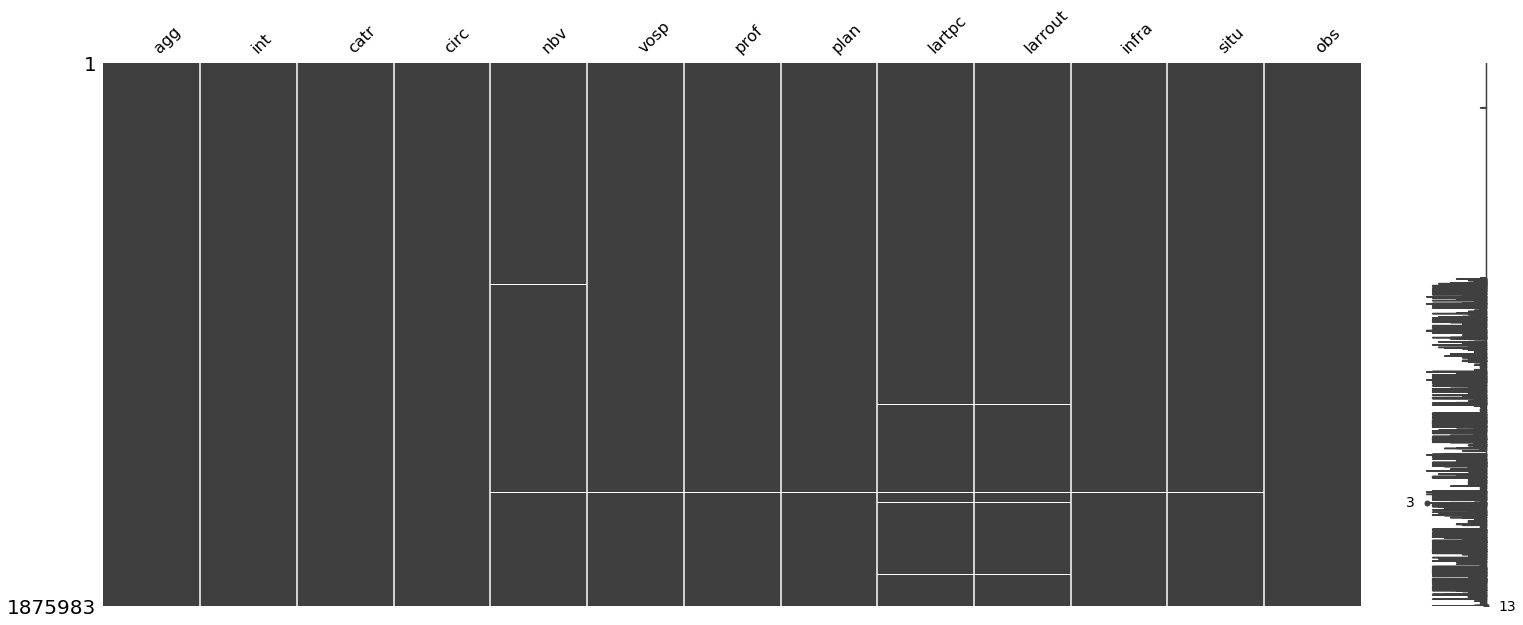

In [183]:
msno.matrix(data_merged.loc[:,col_used])

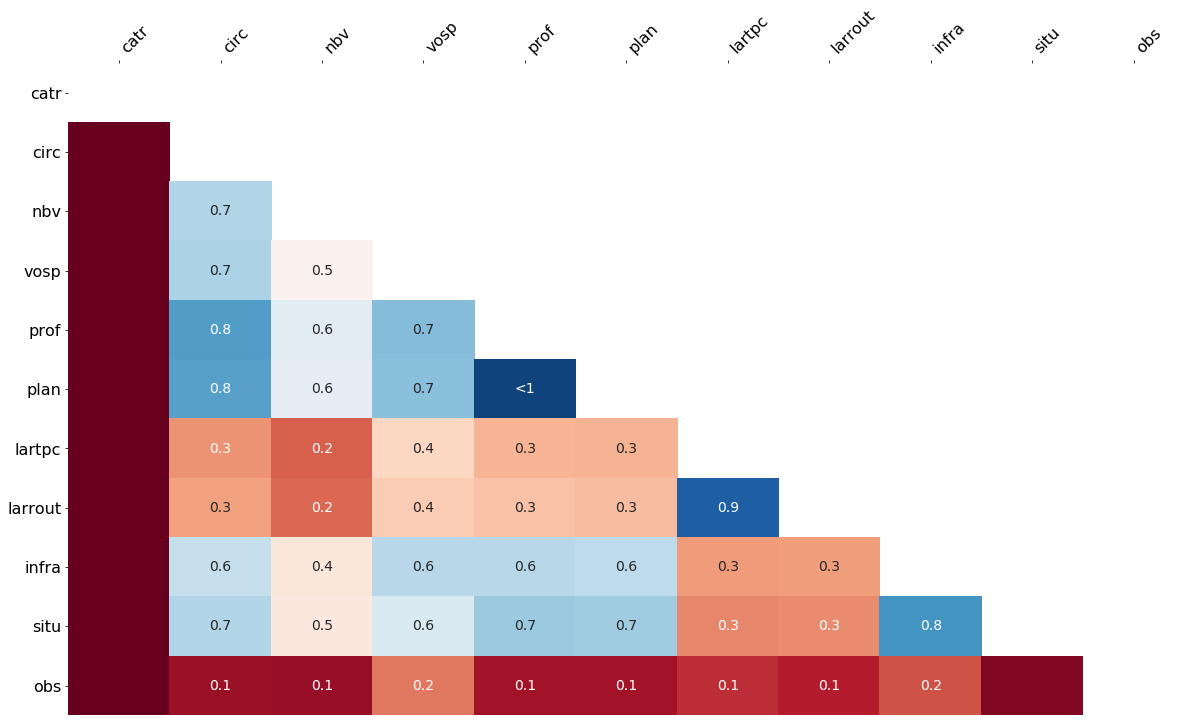

In [17]:
import missingno as msno
msno.heatmap(data_merged.loc[:,col_used])


Le heatmap nous permet de conclure quant à la méthode d'imputation qui doit être utilisée. Cette méthode ne doit pas être stationnaire (imputation par le mode (variables catégorielles) ou la moyenne (variables numériques) car on n'est pas face à un phénomène MCAR, et donc une supression des lignes correspondant aux valeurs manquantes baisera les résultats.

Cependant les données présentent des variables de différents types et les méthodes qui sont utilisées pour l'imputation des valeurs manquantes gérent mieux que les valeurs numériques comme <b>fancyimpute</b> et <b>MICE</b> (Multiple Imputation by Chained Equations)

Par conséquent nous allons opter pour un algorithme qui traitent les valeurs manquantes d'une façon interne. On va choisir <b>xgboost</b> qui traitent les valeurs manquantes d'une telle façon à minimiser la fonction de coût qui lui est propore.

Ceci nous finit pas cette partie, car dans le jeu de données il n'a pas que des nan qui impliquent une valeur manquantes mais aussi des 0 ou enore des cases vides.

###### Aggrégation

Cette partie a pour objectif d'agréger les données préparées selon les attributs prometteurs. La variable à agréger est "grave" et "Num Acc".

Cette aggrégation sera fait sur deux jeu de données : train et test.

le jeu de données du test sera la région Bretagne  et le jeu de données du train sera le reste de la France.

<mark>Split en train/test : </mark>

In [18]:
data_merged.long=data_merged.long.replace('-',np.nan)  # replace - into nan values
data_merged.long=data_merged.long.astype(float)   # change type of long to be float 

In [19]:
# normaliser les coordonnéés  :
data_merged.long=data_merged.long/100000
data_merged.lat=data_merged.lat/100000

In [20]:
#bretagne :
long_min=-4.793000
long_max=-0.880750
lat_max=48.998600
lat_min=47.300030

bretagne=data_merged.loc[((data_merged.long <= long_max )&(data_merged.long >= long_min)),:]
bretagne=bretagne.loc[((bretagne.lat <=lat_max)&(bretagne.lat >= lat_min)),:]

#france : 
france=data_merged.loc[~((data_merged.long<long_max)&(data_merged.long> long_min)),:]
france=france.loc[~((france.lat<lat_max )&(france.lat> lat_min)),:]

#### Données pour la visualisation : 

In [110]:
vis=bretagne.groupby([ 'long','lat']).grav.value_counts()
vis = vis.rename(columns={'grav': 'nb_grav'})
#create dataframe by reseting index : 
vis=vis.reset_index()
vis=vis.rename(columns={0:'nb_grav'})

vis['indemne']=0  # 1
vis['tue']=0  # 2 
vis['hospitalisé']=0  # 3
vis['blessé']=0  # 4 


for i in range(vis.shape[0]):
    if vis.loc[i,'grav']==1 :
        vis.loc[i,'indemne']=vis.loc[i,'nb_grav']
    elif vis.loc[i,'grav']==2 :
        vis.loc[i,'tue']=vis.loc[i,'nb_grav']
    elif vis.loc[i,'grav']==3 :
        vis.loc[i,'hospitalisé']=vis.loc[i,'nb_grav']
    else :
        vis.loc[i,'blessé']=vis.loc[i,'nb_grav']
        
        
vis=vis.groupby([ 'long','lat']).agg({'indemne':['sum'],'tue':['sum'],
                                                                  'hospitalisé':['sum'],'blessé':['sum']})
# create data frame
vis=vis.reset_index()
#rename columns
col_names=['long','lat','indemne','tue','hospitalisé','blessé']
vis.columns=col_names


#--------nb acc
vis_nb=bretagne.groupby(['long','lat']).agg({'Num_Acc':['count']})

#create dataframe :
vis_nb=vis_nb.reset_index()
#rename columns
col_france=['long','lat','nb_acc']
vis_nb.columns=col_france
vis['nb_acc'] = vis_nb['nb_acc']
vis['sc_grav'] =( vis['indemne'] + (vis['blessé'] * np.exp(1)) +
                                   vis['hospitalisé'] * np.exp(2)) + (vis['tue'] * np.exp(3))
#normalize sc_grav
vis['sc_grav_norm']=(vis.sc_grav)/(vis.sc_grav.max())

In [120]:
vis.to_csv('vis.csv',index=False)

In [116]:
vis.shape

(18419, 7)

#### Données pour la modélisation : 

In [ ]:
#group by operation followed by value_couts upon grav variable
#--------------------------------France---------------------------
#group by for france data : 
france_grouped=france.groupby([ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs']).grav.value_counts()
france_grouped = france_grouped.rename(columns={'grav': 'nb_grav'})
#create dataframe by reseting index : 
france_grouped=france_grouped.reset_index()
france_grouped=france_grouped.rename(columns={0:'nb_grav'})


#-----------------------------Bretagne ----------------------------
#group by for bretagne data : 
bretagne_grouped=bretagne.groupby([ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs']).grav.value_counts()
bretagne_grouped = bretagne_grouped.rename(columns={'grav': 'nb_grav'}) # rename aggregated column
#create dataframe by reseting index : 
bretagne_grouped=bretagne_grouped.reset_index()
bretagne_grouped=bretagne_grouped.rename(columns={0:'nb_grav'})

 <b><mark>Création de nouveau d'attributs :</mark></b> ces attributs vont nous permettre de calculer le score de gravité d'une configuration donnée du lieu d'accident.

In [ ]:
#---------------------France ----------------------
france_grouped['indemne']=0  # 1
france_grouped['tue']=0  # 2 
france_grouped['hospitalisé']=0  # 3
france_grouped['blessé']=0  # 4 
#----------------------Bretagbe 
bretagne_grouped['indemne']=0  # 1
bretagne_grouped['tue']=0  # 2 
bretagne_grouped['hospitalisé']=0  # 3
bretagne_grouped['blessé']=0  # 4 

In [ ]:
#fill in new attributs : 
#------------------France ---------------------
for i in range(france_grouped.shape[0]):
    if france_grouped.loc[i,'grav']==1 :
        france_grouped.loc[i,'indemne']=france_grouped.loc[i,'nb_grav']
    elif france_grouped.loc[i,'grav']==2 :
        france_grouped.loc[i,'tue']=france_grouped.loc[i,'nb_grav']
    elif france_grouped.loc[i,'grav']==3 :
        france_grouped.loc[i,'hospitalisé']=france_grouped.loc[i,'nb_grav']
    else :
        france_grouped.loc[i,'blessé']=france_grouped.loc[i,'nb_grav']
        
        
#------------------Bretagne---------------------
for i in range(france_grouped.shape[0]):
    if bretagne_grouped.loc[i,'grav']==1 :
        bretagne_grouped.loc[i,'indemne']=bretagne_grouped.loc[i,'nb_grav']
    elif bretagne_grouped.loc[i,'grav']==2 :
        bretagne_grouped.loc[i,'tue']=bretagne_grouped.loc[i,'nb_grav']
    elif bretagne_grouped.loc[i,'grav']==3 :
        bretagne_grouped.loc[i,'hospitalisé']=bretagne_grouped.loc[i,'nb_grav']
    else :
        bretagne_grouped.loc[i,'blessé']=bretagne_grouped.loc[i,'nb_grav']
        

In [ ]:
#aggregate the last 5 columns to have one row per description of road :
#--------------------------------------France-----------------------------------------------------------------
df_france=france_grouped.groupby([ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc',
                   'larrout', 'infra','situ', 'obs']).agg({'indemne':['sum'],'tue':['sum'],
                                                                  'hospitalisé':['sum'],'blessé':['sum']})
# create data frame
df_france=df_france.reset_index()
#rename columns
col_names=['agg','int','catr','circ', 'nbv', 'vosp', 'prof','plan','lartpc','larrout',
 'infra','situ', 'obs','indemne','tue','hospitalisé','blessé']
df_france.columns=col_names
#---------------------------------------Bretagne---------------------------------------------------------------
df_bretagne=bretagne_grouped.groupby([ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc',
                   'larrout', 'infra','situ', 'obs']).agg({'indemne':['sum'],'tue':['sum'],
                                                                  'hospitalisé':['sum'],'blessé':['sum']})
# create data frame
df_bretagne=df_bretagne.reset_index()
#rename columns
col_names=['agg','int','catr','circ', 'nbv', 'vosp', 'prof','plan','lartpc','larrout',
 'infra','situ', 'obs','indemne','tue','hospitalisé','blessé']
df_bretagne.columns=col_names

In [ ]:
#aggregate data for Num_Acc
#-------------France ------------------------
res_france=france.groupby(['agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc',
                   'larrout', 'infra','situ', 'obs']).agg({'Num_Acc':['count']})

#create dataframe :
res_france=res_france.reset_index()
#rename columns
col_france=['agg','int','catr','circ', 'nbv', 'vosp', 'prof','plan','lartpc','larrout',
 'infra','situ', 'obs','nb_acc']
res_france.columns=col_france
df_france['nb_acc'] = res_france['nb_acc']
#-------------------bretagne
res_bretagne=bretagne.groupby(['agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc',
                   'larrout', 'infra','situ', 'obs']).agg({'Num_Acc':['count']})
#create dataframe :
res_bretagne=res_bretagne.reset_index()
#rename columns
res_bretagne.columns=col_france

In [ ]:
#add nb_acc to df  to represent the seconde column that will allow us to compute risk of accident frequence
#-------------------France ---------------
df_france['nb_acc'] = res_france['nb_acc']

#---------------Bretagne-----------------
df_bratgne['nb_acc']=res_bretagne['nb_acc']

In [ ]:
#save data to csv file :
df_france.to_csv('score-analysis/df_france.csv',index=False)
df_bretagne.to_csv('score-analysis/df_bretagne.csv',index=False)

In [46]:
df_france=pd.read_csv('score-analysis/df_france.csv', encoding='latin-1')
df_bretagne=pd.read_csv('score-analysis/df_bretagne.csv', encoding='latin-1')

###### Feature engineering

Nous allons maintenant créer deux variables cibles : 
    1. score d'accident: une score qui prend en considération la variable nb_acc (nombre d'accidents par configuration de route)
    2. score de gravité : un score qui prend en considération les 4 variables 'indemne','tue','hospitalisé' et 'blessé'.
    
Un score élevé signifie que la configuration de la route est très dangereuse.

On voit très bien la difficulté de créer ces score. L'objectif est de trouver pour chaque score une fonction f(.) qui va fournir ce score.

<mark>Proposition</mark> 

In [ ]:
# score d'accident : 
#-----------------France---------------------
df_france['sc_acc'] =(df_france.nb_acc-df_france.nb_acc.min())/(df_france.nb_acc.max()-df_france.nb_acc.min())
# score de gravité : 
df_france['sc_grav'] =( df_france['indemne'] + (df_france['blessé'] * np.exp(1)) +
                                   (df_france['hospitalisé'] * np.exp(2)) + (df_france['tue'] * np.exp(3)))
#normalize sc_grav
df_france['sc_grav_norm']=(df_france.sc_grav)/(df_france.sc_grav.max())
# create two levels for sc_grav_norm
df_france['risk_gravity']=1
df_france.loc[((df_france['sc_grav_norm']<=df_france.sc_grav_norm.describe()['50%'])),'risk_gravity']=1
df_france.loc[((df_france['sc_grav_norm']>df_france.sc_grav_norm.describe()['50%'])),'risk_gravity']=2
#create two levels for risk_frequency : 
df_france['risk_frequence']=1
df_france.loc[((df_france['sc_acc']<=df_france.sc_acc.describe()['50%'])),'risk_frequence']=1
df_france.loc[((df_france['sc_acc']>df_france.sc_acc.describe()['50%'])),'risk_frequence']=2

#-----------------Bretagne---------------------
df_bretagne['sc_acc'] =(df_bretagne.nb_acc-df_bretagne.nb_acc.min())/(df_bretagne.nb_acc.max()-df_bretagne.nb_acc.min())
# score de gravité : 
df_bretagne['sc_grav'] =( df_bretagne['indemne'] + (df_bretagne['blessé'] * np.exp(1)) +
                                   (df_bretagne['hospitalisé'] * np.exp(2)) + (df_bretagne['tue'] * np.exp(3)))
#normalize sc_grav
df_bretagne['sc_grav_norm']=(df_bretagne.sc_grav)/(df_bretagne.sc_grav.max())
# create two levels for sc_grav_norm
df_bretagne['risk_gravity']=1
df_bretagne.loc[((df_bretagne['sc_grav_norm']<=df_bretagne.sc_grav_norm.describe()['50%'])),'risk_gravity']=1
df_bretagne.loc[((df_bretagne['sc_grav_norm']>df_bretagne.sc_grav_norm.describe()['50%'])),'risk_gravity']=2
#create two levels for risk_frequency : 
df_bretagne['risk_frequence']=1
df_bretagne.loc[((df_bretagne['sc_acc']<=df_bretagne.sc_acc.describe()['50%'])),'risk_frequence']=1
df_bretagne.loc[((df_bretagne['sc_acc']>df_bretagne.sc_acc.describe()['50%'])),'risk_frequence']=2

In [ ]:
#last preparation : 
#-----------France ------------------------
df_france.loc[df_france['lartpc']>10,'lartpc']=10
df_france.loc[df_france['larrout']>74,'larrout']=74
df_france.loc[df_france['nbv']>9,'nbv']=8
df_france.loc[:,'larrout']=df_france.loc[:,'larrout'].replace(-81,75)
df_france.loc[:,'larrout']=10*(df_france.larrout-df_france.larrout.min())/(df_france.larrout.max()-df_france.larrout.min())

#--------------Bretagne
df_bretagne.loc[df_bretagne['lartpc']>10,'lartpc']=10
df_bretagne.loc[df_bretagne['larrout']>74,'larrout']=74
df_bretagne.loc[df_bretagne['nbv']>9,'nbv']=8
df_bretagne.loc[:,'larrout']=df_bretagne.loc[:,'larrout'].replace(-81,75)
df_bretagne.loc[:,'larrout']=10*(df_bretagne.larrout-df_bretagne.larrout.min())/(df_bretagne.larrout.max()-df_bretagne.larrout.min())

In [ ]:
#save data to csv file :
df_france.to_csv('score-analysis/df_france.csv',index=False)
df_bretagne.to_csv('score-analysis/df_bretagne.csv',index=False)

In [21]:
df_france=pd.read_csv('score-analysis/df_france.csv', encoding='latin-1')
df_bretagne=pd.read_csv('score-analysis/df_bretagne.csv', encoding='latin-1')

In [22]:
my_col=col_used+['nb_acc','indemne','blessé','hospitalisé','tue','risk_frequence','risk_gravity']
df_france.loc[:,my_col].head()

,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,infra,situ,obs,nb_acc,indemne,blessé,hospitalisé,tue,risk_frequence,risk_gravity
0,1,0,1.0,1.0,1.0,0.0,1.0,1.0,10.0,4.729730,3.0,1.0,0.0,1,0,1,0,0,1,1
1,1,0,1.0,1.0,2.0,0.0,2.0,3.0,0.0,10.000000,0.0,1.0,3.0,4,3,0,1,0,2,2
2,1,0,1.0,1.0,3.0,0.0,1.0,1.0,2.0,1.351351,0.0,1.0,3.0,2,0,0,0,2,1,2
3,1,0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,2,1,0,1,0,1,2
4,1,0,2.0,3.0,3.0,0.0,1.0,1.0,10.0,10.000000,0.0,1.0,4.0,1,0,1,0,0,1,1


## Modélisation & Evaluation


##### Choix de l'algorithme : 

### 1. Score de gravité :

### KNN : KNeighborsClassifier

L'algorithme KNN est un classificateur robuste et polyvalent qui est souvent utilisé comme référence pour des classificateurs plus complexes tels que les réseaux neuronaux artificiels (ANN) et les SVM. Malgré sa simplicité, KNN peut surpasser les classificateurs plus puissants et est utilisé dans une variété d'applications telles que la prévision économique, la compression de données et la génétique.

#### Formalisation de l'algorithme:

Commençons par établir des définitions et des notations. Nous utiliserons x pour désigner une variable indépendente (feature predictor, attribut) et y pour désigner la cible (label, class) que nous essayons de prédire.

KNN tombe dans la famille d'algorithmes d'apprentissage supervisé. De manière informelle, cela signifie que nous recevons un ensemble de données étiqueté contenant des observations d'entraînement (x, y) et que nous souhaitons capturer la relation entre x et y. Plus formellement, notre but est d'apprendre une fonction h: X → Y qui, étant donné une observation invisible x, h(x) peut prédire avec confiance la sortie y correspondante.

Le classificateur KNN est également un algorithme d'apprentissage non paramétrique et basé sur l'instance (instance based)

<b>Non-paramétrique</b> :  signifie qu'il ne fait aucune supposition explicite sur la forme fonctionnelle de h, évitant les dangers de ne pas bien modéliser la distribution sous-jacente des données. Par exemple, supposons que nos données soient hautement non gaussiennes mais le modèle d'apprentissage que nous choisissons suppose une forme gaussienne. Dans ce cas, notre algorithme ferait des prédictions extrêmement pauvres.

<b>L'apprentissage par instance</b> : signifie que notre algorithme n'apprend pas explicitement un modèle. Au lieu de cela, il choisit de mémoriser les instances d'entraînement qui sont ensuite utilisées comme «connaissances» pour la phase de prédiction. Concrètement, cela signifie que seulement quand une requête à notre base de données est faite (c'est-à-dire quand nous lui demandons de prédire une étiquette donnée une entrée), l'algorithme utilisera-t-il les instances de formation pour trouver une réponse.

##### KNN mathématiquement: 

voir lien ( à faire dans le rapport)

###### Equilibre des modalités dans la classe:

In [24]:
#train data : 
df_france.risk_gravity.value_counts()/df_france.shape[0] #===> balanced data so accuracy as performance measure

1    0.510543
2    0.489457
Name: risk_gravity, dtype: float64

In [25]:
df_bretagne.risk_gravity.value_counts()/df_bretagne.shape[0] #===> balanced data so accuracy as performance measure

1    0.604974
2    0.395026
Name: risk_gravity, dtype: float64

On peut dire que la distribution  est la même pour la variable cible dans les deux jeu de données.

###### Valeur de départ pour K

In [26]:
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_gravity']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_gravity.values  # target column
X=data_train.loc[:,data_train.columns!='risk_gravity']  # feature data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
print('Une valeur de départ pour K est : ', np.sqrt(X_train.shape[0])/2)


Une valeur de départ pour K est :  215.059294149


In [230]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 215)
knn_215 = KNeighborsClassifier(n_neighbors=215,n_jobs=-1, metric='euclidean',weights='distance')

# fitting the model
knn_215.fit(X_train, y_train)

# predict the response
pred = knn_215.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_215.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_215.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.5f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.5f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 84.16450%
Accuracy on test set : 61.32027%
Confusion matrix : 
  [[24411 15935]
 [14733 24208]]
Classification report : 
               precision    recall  f1-score   support

          1       0.62      0.61      0.61     40346
          2       0.60      0.62      0.61     38941

avg / total       0.61      0.61      0.61     79287



In [232]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 215)
knn_215 = KNeighborsClassifier(n_neighbors=215,n_jobs=-1, metric='euclidean')

# fitting the model
knn_215.fit(X_train, y_train)

# predict the response
pred = knn_215.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_215.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_215.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.5f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.5f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 63.08472%
Accuracy on test set : 62.52854%
Confusion matrix : 
  [[22296 18050]
 [11660 27281]]
Classification report : 
               precision    recall  f1-score   support

          1       0.66      0.55      0.60     40346
          2       0.60      0.70      0.65     38941

avg / total       0.63      0.63      0.62     79287



<mark>Les résultats sont globalement bons mais on voit qu'il y a de l'overfitting donc nous allons chercher la  valeur optimale pour K.</mark>

###### Paramétrage avec validation croisée

Dans cette section, nous allons explorer une méthode qui peut être utilisée pour régler l'hyperparamètre K.

Évidemment, le meilleur K est celui qui correspond au plus faible taux d'erreur de test, supposons donc que nous effectuons des mesures répétées de l'erreur de test pour différentes valeurs de K. Par inadvertance, nous utilisons l'ensemble de test comme ensemble d'apprentissage ! Cela signifie que nous sous-estimons le taux d'erreur réel puisque notre modèle a été contraint d'adapter le test de la meilleure façon possible. Notre modèle est alors incapable de généraliser à des observations plus récentes, un processus connu sous le nom de surapprentissage (overfitting). Par conséquent, toucher l'ensemble de test est hors de question et doit seulement être fait à la toute fin de notre pipeline.

Une approche alternative et plus intelligente consiste à estimer le taux d'erreurs de test en présentant un sous-ensemble de l'ensemble d'apprentissage à partir du processus d'ajustement. Ce sous-ensemble, appelé ensemble de validation, peut être utilisé pour sélectionner le niveau de flexibilité approprié de notre algorithme! Il existe différentes approches de validation qui sont utilisées dans la pratique, et nous explorerons l'une des plus populaires, la validation croisée par k-fold.

![](cross_validation.png)

Comme on le voit sur l'image, la validation croisée k-fold (le k est totalement indépendant de K) consiste à diviser de façon aléatoire l'ensemble d'apprentissage en k groupes, ou plis, de taille approximativement égale. Le premier pli est traité comme un ensemble de validation, et la méthode est ajustée sur les plis k-1 restants. Le taux de mauvaise classification est ensuite calculé sur les observations dans le pli bloqué. Cette procédure est répétée k fois; chaque fois, un groupe d'observations différent est traité comme un ensemble de validation. Ce processus se traduit par k estimations de l'erreur de test qui sont ensuite moyennées.

In [257]:
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_gravity']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_gravity.values  # target column
X=data_train.loc[:,data_train.columns!='risk_gravity']  # feature data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


(185002, 12)

In [275]:
data_train=df_france.loc[:,col_train]
# split data into target and feature data : training
y=data_train.risk_gravity.values  # target column
X=data_train.loc[:,data_train.columns!='risk_gravity']  # feature data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
X_train.shape

(185002, 12)

In [276]:
from sklearn.model_selection import  cross_val_score
# creating odd list of K for KNN
k_values=[k for k in range(203,260,2)]
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1, metric='euclidean')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 205


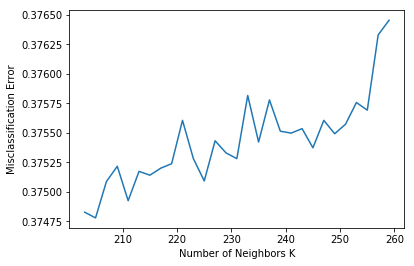

In [277]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = k_values[MSE.index(min(MSE))]
print( "The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(k_values, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

###### Using the optimal number of K

In [27]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_gravity']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_gravity.values  # target column
X=data_train.loc[:,data_train.columns!='risk_gravity']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = optimal_k)
knn = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean')

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.5f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.5f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 63.08689%
Accuracy on test set : 62.56637%
Confusion matrix : 
  [[22286 18060]
 [11620 27321]]
Classification report : 
               precision    recall  f1-score   support

          1       0.66      0.55      0.60     40346
          2       0.60      0.70      0.65     38941

avg / total       0.63      0.63      0.62     79287



Accuracy on train set : 65.86%
Accuracy on test set : 65.47%
Confsuion matrix : 
  [[27353 12993]
 [14385 24556]]
Classification report : 
               precision    recall  f1-score   support

          1       0.66      0.68      0.67     40346
          2       0.65      0.63      0.64     38941

avg / total       0.65      0.65      0.65     79287



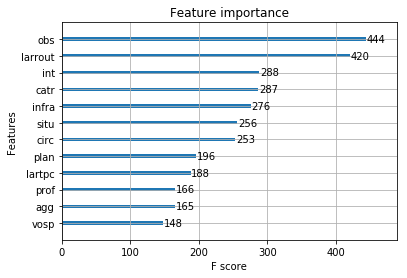

In [225]:
#xgboost : max_depth=5
from xgboost import XGBClassifier
from xgboost import plot_importance
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_gravity']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_gravity.values  # target column
X=data_train.loc[:,data_train.columns!='risk_gravity']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=5) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
plot_importance(xgboost_model)
plt.show()


Accuracy on train set : 64.70%
Accuracy on test set : 64.70%
Confsuion matrix : 
  [[26491 13855]
 [14134 24807]]
Classification report : 
               precision    recall  f1-score   support

          1       0.65      0.66      0.65     40346
          2       0.64      0.64      0.64     38941

avg / total       0.65      0.65      0.65     79287



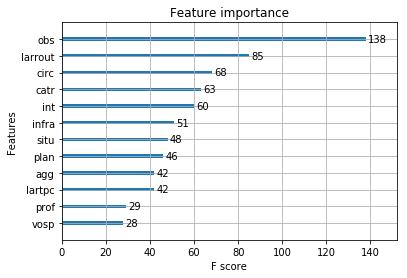

In [228]:
from xgboost import XGBClassifier
from xgboost import plot_importance
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_gravity']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_gravity.values  # target column
X=data_train.loc[:,data_train.columns!='risk_gravity']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=3) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
plot_importance(xgboost_model)
plt.show()


In [28]:
#knn for gravity : 
with open('flask-app/flask-app/pkl_objects/knn.pkl', 'wb') as fid:
    pickle.dump(knn, fid,2) 

## 2. Score d'accidents : 

In [29]:
#create two levels for risk_frequency : 
df_france['risk_frequence']=1
df_france.loc[df_france['nb_acc']<=3,'risk_frequence']=1  # accidents pas fréquents
df_france.loc[df_france['nb_acc']>3,'risk_frequence']=2  # accidents très fréquents 

df_bretagne['risk_frequence']=1
df_bretagne.loc[df_bretagne['nb_acc']<=3,'risk_frequence']=1
df_bretagne.loc[df_bretagne['nb_acc']>3,'risk_frequence']=2

###### KNN with the optimal K values founded previously :

A noter que j'ai essayé au début de définir risk_frequence avec un seuil égale au moyen (moyen du nombre d'accidents) mais cela donne de l'overfitting ( 91% train et 60% test) Puis j'ai choisi le troisième quartile (75%) dont les résultats sont ci-dessus : 

In [30]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_frequence']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_frequence.values  # target column
X=data_train.loc[:,data_train.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = 205)
knn_frequence = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean')

# fitting the model
knn_frequence.fit(X_train, y_train)

# predict the response
pred = knn_frequence.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_frequence.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_frequence.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 77.70%
Accuracy on test set : 77.18%
Confusion matrix : 
  [[55576  4909]
 [13186  5616]]
Classification report : 
               precision    recall  f1-score   support

          1       0.81      0.92      0.86     60485
          2       0.53      0.30      0.38     18802

avg / total       0.74      0.77      0.75     79287



In [32]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_frequence']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_frequence.values  # target column
X=data_train.loc[:,data_train.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = 265)
knn_frequence = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean',weights='distance')

# fitting the model
knn_frequence.fit(X_train, y_train)

# predict the response
pred = knn_frequence.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_frequence.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_frequence.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 87.52%
Accuracy on test set : 76.17%
Confusion matrix : 
  [[54761  5724]
 [13169  5633]]
Classification report : 
               precision    recall  f1-score   support

          1       0.81      0.91      0.85     60485
          2       0.50      0.30      0.37     18802

avg / total       0.73      0.76      0.74     79287



Les résultats sont beaucoup mieux par rapport au cas précedent.
Mais on voit toujours que la classe minoritaire a des résultats incomprable avec les classe majoritaire

In [34]:
data_train.risk_frequence.value_counts().values[0]/data_train.shape[0],data_train.risk_frequence.value_counts().values[1]/data_train.shape[0]

(0.7645910348141618, 0.23540896518583823)

###### UnderSampling :  resample method 

In [33]:
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_frequence']
data_train=df_france.loc[:,col_train]
data_train.risk_frequence.value_counts()

1    202073
2     62216
Name: risk_frequence, dtype: int64

In [34]:
# Separate majority and minority classes
df_majority = data_train[data_train.risk_frequence==1]
df_minority = data_train[data_train.risk_frequence==2]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=62216,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.risk_frequence.value_counts()
df_downsampled.head()

,agg,int,catr,circ,vosp,prof,plan,lartpc,larrout,infra,situ,obs,risk_frequence
112664,2,1,3.0,0.0,0.0,0.0,1.0,10.0,0.000000,0.0,1.0,0.0,1
182160,2,1,4.0,3.0,1.0,2.0,1.0,0.0,9.459459,0.0,1.0,0.0,1
260176,2,9,3.0,2.0,0.0,1.0,0.0,0.0,10.000000,0.0,1.0,0.0,1
178493,2,1,4.0,2.0,0.0,1.0,1.0,0.0,10.000000,5.0,1.0,0.0,1
18065,1,1,1.0,3.0,0.0,1.0,1.0,10.0,10.000000,0.0,1.0,4.0,1


###### sans weights : 

In [35]:
# loading library
from sklearn.neighbors import KNeighborsClassifier


# split data into target and feature data : training
y=df_downsampled.risk_frequence.values  # target column
X=df_downsampled.loc[:,df_downsampled.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = 265)
knn_frequence = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean')

# fitting the model
knn_frequence.fit(X_train, y_train)

# predict the response
pred = knn_frequence.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_frequence.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_frequence.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 64.68%
Accuracy on test set : 64.44%
Confusion matrix : 
  [[ 9250  9482]
 [ 3792 14806]]
Classification report : 
               precision    recall  f1-score   support

          1       0.71      0.49      0.58     18732
          2       0.61      0.80      0.69     18598

avg / total       0.66      0.64      0.64     37330



###### avec weights : 

In [36]:
# loading library
from sklearn.neighbors import KNeighborsClassifier


# split data into target and feature data : training
y=df_downsampled.risk_frequence.values  # target column
X=df_downsampled.loc[:,df_downsampled.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = 265)
knn_frequence = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean',weights='distance')

# fitting the model
knn_frequence.fit(X_train, y_train)

# predict the response
pred = knn_frequence.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_frequence.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_frequence.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 86.57%
Accuracy on test set : 63.70%
Confusion matrix : 
  [[10217  8515]
 [ 5034 13564]]
Classification report : 
               precision    recall  f1-score   support

          1       0.67      0.55      0.60     18732
          2       0.61      0.73      0.67     18598

avg / total       0.64      0.64      0.63     37330



###### Oversampling :

In [37]:
# Separate majority and minority classes
df_majority = data_train[data_train.risk_frequence==1]
df_minority = data_train[data_train.risk_frequence==2]
 
# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=202073,     # to match majority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.risk_frequence.value_counts()
df_upsampled.head()

,agg,int,catr,circ,vosp,prof,plan,lartpc,larrout,infra,situ,obs,risk_frequence
0,1,0,1.0,1.0,0.0,1.0,1.0,10.0,4.729730,3.0,1.0,0.0,1
2,1,0,1.0,1.0,0.0,1.0,1.0,2.0,1.351351,0.0,1.0,3.0,1
3,1,0,2.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,1
4,1,0,2.0,3.0,0.0,1.0,1.0,10.0,10.000000,0.0,1.0,4.0,1
7,1,0,3.0,2.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.0,0.0,1


###### sans weights : 

In [39]:
# loading library
from sklearn.neighbors import KNeighborsClassifier


# split data into target and feature data : training
y=df_upsampled.risk_frequence.values  # target column
X=df_upsampled.loc[:,df_upsampled.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = 265)
knn_frequence = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean')

# fitting the model
knn_frequence.fit(X_train, y_train)

# predict the response
pred = knn_frequence.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_frequence.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_frequence.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 66.27%
Accuracy on test set : 65.71%
Confusion matrix : 
  [[30786 29777]
 [11793 48888]]
Classification report : 
               precision    recall  f1-score   support

          1       0.72      0.51      0.60     60563
          2       0.62      0.81      0.70     60681

avg / total       0.67      0.66      0.65    121244



###### avec weights : 

In [40]:
# loading library
from sklearn.neighbors import KNeighborsClassifier


# split data into target and feature data : training
y=df_upsampled.risk_frequence.values  # target column
X=df_upsampled.loc[:,df_upsampled.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

# instantiate learning model (k = 265)
knn_frequence = KNeighborsClassifier(n_neighbors=205,n_jobs=-1, metric='euclidean',weights='distance')

# fitting the model
knn_frequence.fit(X_train, y_train)

# predict the response
pred = knn_frequence.predict(X_test)
#evaluate on train set to assist overfitting : 
y_pred_train=knn_frequence.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=knn_frequence.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))

Accuracy on train set : 85.46%
Accuracy on test set : 72.58%
Confusion matrix : 
  [[36055 24508]
 [ 8740 51941]]
Classification report : 
               precision    recall  f1-score   support

          1       0.80      0.60      0.68     60563
          2       0.68      0.86      0.76     60681

avg / total       0.74      0.73      0.72    121244



#### Xgboost :

In [249]:
df_france.risk_frequence.value_counts()
202073/62216


3.2479265783721227

Accuracy on train set : 67.67%
Accuracy on test set : 67.34%
Confsuion matrix : 
  [[40421 20064]
 [ 5833 12969]]
Classification report : 
               precision    recall  f1-score   support

          1       0.87      0.67      0.76     60485
          2       0.39      0.69      0.50     18802

avg / total       0.76      0.67      0.70     79287



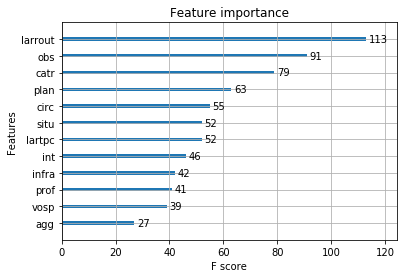

In [252]:
from xgboost import XGBClassifier
from xgboost import plot_importance
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_frequence']
data_train=df_france.loc[:,col_train]

# split data into target and feature data : training
y=data_train.risk_frequence.values  # target column
X=data_train.loc[:,data_train.columns!='risk_frequence']  # feature data

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=3,scale_pos_weight=3.24) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confsuion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
plot_importance(xgboost_model)
plt.show()


In [42]:
#knn for frequence : 
with open('flask-app/flask-app/pkl_objects/knn_frequence.pkl', 'wb') as fid:
    pickle.dump(knn_frequence, fid,2) 

Conclusion : on garde notre algorithme avec upsampling

# Déploiement :

In [130]:
import pickle

#reload knn for gravity : 
knn = pickle.load(open('knn.pkl', 'rb'))

#reload knn_frequence for frequence
knn_frequence = pickle.load(open('knn_frequence.pkl', 'rb'))

L'application qui sera mise en production va permettre à un utilisateur d'entrer une  configuration d'une route puis l'application va lui rendre :
1. un score de gravité d'accident et de fréquence avec les probabilités corresspondants
2. trouver les plus proches routes dans la base de données 
4. proposer un aménagement possible avec la plus proche configuration et qui a un score très faible de gravité.


<mark>Application :</mark> 
- input : [  'agg', 'int', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'infra', 'situ', 'obs']
 
 Les inputs doievent être compréhensible par l'utilisateur, donc c'est à nous de faire le traitement des valeurs saisies pour qu'elles soient cohérentes avec les données d'apprentissage et du test
 
 
 - output :  ['risk_gravity']  ['risk_frequence'] and probabilities



In [131]:
def prediction_gravity_frequence(new_instance,n_voisins=265):
    '''
    Parameters : 
        - new_instance : 
        - n_voisins : 
    
    
    Returns : 
        -  two Dataframes  : 
    
    
    
    '''
    #gravity : 
    prediction_gravity= knn.predict(new_instance.reshape(1, -1))
    prediction_gravity_proba= knn.predict_proba(new_instance.reshape(1, -1) )
    
    #frequence : 
    prediction_frequence= knn_frequence.predict(new_instance.reshape(1, -1) )
    prediction_frequence_proba= knn_frequence.predict_proba(new_instance.reshape(1, -1) )
    #results into a dataframe  :
    my_dict=new_instance.to_dict()
    res=pd.DataFrame(my_dict,index=[0])
    #print(prediction_gravity[0],prediction_frequence[0],prediction_gravity_proba[0][prediction_gravity-1][0],
    #      prediction_frequence_proba[0][prediction_frequence-1][0])
    #gravity results : 
    if prediction_gravity[0]==1 :
         res['la gravité']='Route non dangereuse'
    else : 
        res['la gravité']='Route très dangereuse'
    res['probabilité de la gravité']=prediction_gravity_proba[0][prediction_gravity-1][0]
    #frequence results :  
    if prediction_frequence[0]==1 :
         res['la fréquence des accidents']='accidents non fréquents'
    else : 
        res['la fréquence des accidents']='accidents très fréquents'
    res['probabilité de la fréquence']=prediction_frequence_proba[0][prediction_frequence-1][0]
    
    
    # amenagement dans le cas où la route est très dangereuse : *voir fonction ci-dessous
    if prediction_gravity[0]==2:
        solution=amengament(new_instance,n_voisins)
        
        
    return res,solution

In [132]:
def amengament(instance,n_voisins=265):
    '''
    cette fonction propose un améngement pour une route très dangereuse.
    Elle permet de chercher dans la base les plus proches voisin dont le risk de gravité est nulle.
    '''
    ###### trouvons les plus proches voisin à cette route en utilisant knn de la gravité : 
    voisins= knn.kneighbors(instance.reshape(1, -1),n_neighbors=n_voisins,return_distance=False)
    res=pd.DataFrame()
    for j in range(n_voisins) :
        i=voisins[0][j] # get index of the first neighbor for the instance used for validation ( here j=0)
        risk_road=df_france.loc[i,'risk_gravity']  # get classification of the neighbor
        if risk_road==1:
            my_dict=df_france.loc[i,col_train].to_dict()
            del my_dict['risk_gravity']
            del my_dict['risk_frequence']
            df=pd.DataFrame(my_dict,index=[0])
            res=pd.concat([res,df])
    #retransforme larrout :
    res['larrout']=(1/10)*res['larrout']*((df_bretagne.larrout.max()-df_bretagne.larrout.min()))+df_bretagne.larrout.min()
    # create index : 
    res=res.reset_index()
    res=res.iloc[:,1:]
    return res

#### Test de la solution :

In [133]:
#validation data : 
col_train =[ 'agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout' ,'infra', 'situ', 'obs', 'risk_gravity','risk_frequence']
# df_bretagne est le jeu de validation de notre solution 
validation=df_bretagne.loc[:,col_train]
# instance à valider : on l'a choisit car elle est très dangereuse et on veut vérifier que les résultats fournis par notre solution 
# correspond bien à ce qui est dans le jeu de données.
instance=validation.iloc[47,:-2]   # retirer les variables cibles 

In [160]:
resultas = prediction_gravity_frequence(instance,n_voisins=219)[0]
amengament_propose = prediction_gravity_frequence(instance,n_voisins=219)[1]

In [161]:
# resultats 
resultas

,agg,catr,circ,infra,int,larrout,lartpc,obs,plan,prof,situ,vosp,la gravité,probabilité de la gravité,la fréquence des accidents,probabilité de la fréquence
0,1.0,1.0,3.0,0.0,1.0,9.459459,0.0,0.0,1.0,1.0,1.0,0.0,Route très dangereuse,1.0,accidents très fréquents,1.0


In [162]:
# amengament proposé :
amengament_propose.head()

,agg,catr,circ,infra,int,larrout,lartpc,obs,plan,prof,situ,vosp
0,2.0,2.0,1.0,0.0,1.0,10.000000,0.0,14.0,1.0,1.0,1.0,0.0
1,2.0,4.0,2.0,0.0,1.0,8.378378,10.0,0.0,3.0,1.0,1.0,0.0
2,1.0,3.0,2.0,0.0,9.0,0.000000,10.0,0.0,1.0,1.0,1.0,0.0
3,2.0,4.0,2.0,0.0,1.0,10.000000,0.0,0.0,1.0,1.0,1.0,0.0
4,2.0,4.0,1.0,0.0,1.0,3.378378,0.0,0.0,1.0,1.0,1.0,2.0


Commentaire :

 - Resultats bons
 - Mais cela nécessaite encore de filtre :  par exemple si on veut pas changer la catégorie de route, ... 
 
améliorons notre solution  :

In [52]:
def prediction_gravity_frequence(new_instance,n_voisins):
    '''
    Parameters : 
        - new_instance : 
        - n_voisins : 
    
    
    Returns : 
        -  two Dataframes  : 
    
    
    
    '''
    #gravity : 
    prediction_gravity= knn.predict(new_instance.reshape(1, -1))
    prediction_gravity_proba= knn.predict_proba(new_instance.reshape(1, -1) )
    
    #frequence : 
    prediction_frequence= knn_frequence.predict(new_instance.reshape(1, -1) )
    prediction_frequence_proba= knn_frequence.predict_proba(new_instance.reshape(1, -1) )
    #results into a dataframe  :
    my_dict=new_instance.to_dict()
    res=pd.DataFrame(my_dict,index=[0])
    #print(prediction_gravity[0],prediction_frequence[0],prediction_gravity_proba[0][prediction_gravity-1][0],
    #      prediction_frequence_proba[0][prediction_frequence-1][0])
    #gravity results : 
    if prediction_gravity[0]==1 :
         res['la gravité']='Route non dangereuse'
    else : 
        res['la gravité']='Route très dangereuse'
    res['probabilité de la gravité']=prediction_gravity_proba[0][prediction_gravity-1][0]
    #frequence results :  
    if prediction_frequence[0]==1 :
         res['la fréquence des accidents']='accidents non fréquents'
    else : 
        res['la fréquence des accidents']='accidents très fréquents'
    res['probabilité de la fréquence']=prediction_frequence_proba[0][prediction_frequence-1][0]
    
    
    # amenagement dans le cas où la route est très dangereuse : *voir fonction ci-dessous
    if prediction_gravity[0]==2:
        solution=amengament(new_instance,n_voisins)
    
    # filtre sur la solution : 
    
    # il faut récuperer leurs valeurs  :
    agg_value=instance.to_dict()['agg']
    catr_value=instance.to_dict()['catr']
    solution=solution.loc[((solution['agg']==agg_value)&(solution['catr']==catr_value)),:]  
    return res,solution

In [145]:
resultas = prediction_gravity_frequence(instance,n_voisins=100)[0]
amengament_propose = prediction_gravity_frequence(instance,n_voisins=100)[1]

Reste à faire  : 

    1- ajouter les *** dans les paramétres pour les filtres 
    
    2- ajouter condition sur quel critère on fait aménagement : si que l'un des score==2 on fait l'aménagement dessus 
        si les deux valent 2 alors on laisse le choix au utilisateur de choisir sur quel critére on fait l'améngament
        
    3- Application Flask finale.

# Test intégrale sur la Bretagne : 

In [141]:
bretagne.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais
519,200500000220,5,1,1,1830,5,2,1,1.0,1.0,...,1.0,1,4,1,5.0,21.0,0.0,0.0,0.0,1983.0
520,200500000220,5,1,1,1830,5,2,1,1.0,1.0,...,1.0,1,4,1,5.0,21.0,0.0,0.0,0.0,1989.0
523,200500000222,5,1,24,1800,5,1,1,2.0,3.0,...,1.0,1,4,1,1.0,21.0,0.0,0.0,0.0,1986.0
524,200500000222,5,1,24,1800,5,1,1,2.0,3.0,...,1.0,1,1,1,4.0,11.0,0.0,0.0,0.0,1949.0
525,200500000223,5,1,22,1700,1,1,1,2.0,3.0,...,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1986.0


In [142]:
vis=bretagne.groupby([ 'long','lat', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs']).grav.value_counts()
vis = vis.rename(columns={'grav': 'nb_grav'})
#create dataframe by reseting index : 
vis=vis.reset_index()
vis=vis.rename(columns={0:'nb_grav'})



In [149]:
vis['indemne']=0  # 1
vis['tue']=0  # 2 
vis['hospitalisé']=0  # 3
vis['blessé']=0  # 4 


for i in range(vis.shape[0]):
    if vis.loc[i,'grav']==1 :
        vis.loc[i,'indemne']=vis.loc[i,'nb_grav']
    elif vis.loc[i,'grav']==2 :
        vis.loc[i,'tue']=vis.loc[i,'nb_grav']
    elif vis.loc[i,'grav']==3 :
        vis.loc[i,'hospitalisé']=vis.loc[i,'nb_grav']
    else :
        vis.loc[i,'blessé']=vis.loc[i,'nb_grav']
        
        
vis=vis.groupby([ 'long','lat', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs']).agg({'indemne':['sum'],'tue':['sum'],
                                                                  'hospitalisé':['sum'],'blessé':['sum']})
# create data frame
vis=vis.reset_index()
#rename columns
col_names=['long','lat', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs','indemne','tue','hospitalisé','blessé']
vis.columns=col_names


#--------nb acc
vis_nb=bretagne.groupby(['long','lat', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs']).agg({'Num_Acc':['count']})

#create dataframe :
vis_nb=vis_nb.reset_index()
#rename columns
col_france=['long','lat', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 
                                  'plan', 'lartpc','larrout', 'infra','situ', 'obs','nb_acc']
vis_nb.columns=col_france
vis['nb_acc'] = vis_nb['nb_acc']
vis['sc_grav'] =( vis['indemne'] + (vis['blessé'] * np.exp(1)) +
                                   vis['hospitalisé'] * np.exp(2)) + (vis['tue'] * np.exp(3))
#normalize sc_grav
vis['sc_grav_norm']=(vis.sc_grav)/(vis.sc_grav.max())

In [150]:
vis.head()

,long,lat,agg,int,catr,circ,nbv,vosp,prof,plan,...,infra,situ,obs,indemne,tue,hospitalisé,blessé,nb_acc,sc_grav,sc_grav_norm
0,-4.79300,48.41700,1,1,4.0,2.0,2.0,0.0,1.0,1.0,...,0.0,1.0,0.0,2,0,0,0,2,2.000000,0.013419
1,-4.79300,48.41700,1,1,4.0,2.0,2.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0,0,0,1,1,2.718282,0.018238
2,-4.77871,48.42501,2,1,4.0,2.0,2.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1,0,1,0,2,8.389056,0.056285
3,-4.77800,48.36200,1,1,3.0,2.0,0.0,0.0,2.0,3.0,...,0.0,1.0,0.0,0,0,1,3,4,15.543902,0.104290
4,-4.77500,48.35900,2,1,3.0,2.0,2.0,0.0,2.0,3.0,...,0.0,1.0,0.0,0,0,0,1,1,2.718282,0.018238


In [165]:
X_train.head()

,agg,int,catr,circ,vosp,prof,plan,lartpc,larrout,infra,situ,obs
88091,1,2,3.0,2.0,0.0,3.0,1.0,0.0,9.864865,0.0,1.0,0.0
222549,2,3,3.0,2.0,0.0,1.0,2.0,0.0,6.756757,5.0,1.0,0.0
19036,1,1,1.0,3.0,0.0,2.0,1.0,10.0,10.000000,0.0,1.0,2.0
126180,2,1,3.0,2.0,0.0,2.0,1.0,0.0,6.621622,0.0,1.0,14.0
233613,2,3,4.0,2.0,0.0,1.0,1.0,0.0,8.378378,0.0,1.0,0.0


In [166]:
X_train.columns

Index(['agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc',
       'larrout', 'infra', 'situ', 'obs'],
      dtype='object')

In [173]:
bretagne_test_grav=knn.predict(vis.loc[:,['agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout', 'infra', 'situ', 'obs']])

In [174]:
bretagne_test_fre=knn_frequence.predict(vis.loc[:,['agg', 'int', 'catr', 'circ', 'vosp', 'prof', 'plan', 'lartpc','larrout', 'infra', 'situ', 'obs']])

In [175]:
vis['bretagne_test_grav']=bretagne_test_grav

In [176]:
vis['bretagne_test_fre']=bretagne_test_fre

In [178]:
vis=vis.loc[:,['long','lat','bretagne_test_grav','bretagne_test_fre','risk_gravity','risk_frequence']]

In [179]:
vis.to_csv('bretagne_test.csv',index=False)

In [172]:
# create two levels for sc_grav_norm
vis['risk_gravity']=1
vis.loc[((vis['sc_grav_norm']<=vis.sc_grav_norm.describe()['50%'])),'risk_gravity']=1
vis.loc[((vis['sc_grav_norm']>vis.sc_grav_norm.describe()['50%'])),'risk_gravity']=2
#create two levels for risk_frequency : 
vis['risk_frequence']=1
vis['sc_acc'] =(vis.nb_acc-vis.nb_acc.min())/(vis.nb_acc.max()-vis.nb_acc.min())
vis.loc[((vis['sc_acc']<=vis.sc_acc.describe()['50%'])),'risk_frequence']=1
vis.loc[((vis['sc_acc']>vis.sc_acc.describe()['50%'])),'risk_frequence']=2

In [216]:
print(classification_report(vis.risk_gravity, bretagne_test_grav))

             precision    recall  f1-score   support

          1       0.68      0.29      0.41     10565
          2       0.51      0.84      0.64      9246

avg / total       0.60      0.55      0.51     19811



In [213]:
print(classification_report(vis.risk_frequence,bretagne_test_fre))

             precision    recall  f1-score   support

          1       0.84      0.27      0.41     15347
          2       0.25      0.83      0.38      4464

avg / total       0.71      0.40      0.40     19811

